In [66]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import chardet
file_path='/Users/circleLee/Develop/workspace_py/nlp/week06/data/archive/Summary of Weather.csv'
#ascii
data = pd.read_csv(file_path, sep=',', encoding='ascii')

/var/folders/j7/jk94b4xn57g1p5gbnv0z33080000gp/T/ipykernel_8502/300033780.py:7: DtypeWarning: Columns (7,8,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, sep=',', encoding='ascii')


In [76]:
#数据预处理
# 确保日期为datetime类型并按时间排序
data["Date"] = pd.to_datetime(data["Date"])
data = data.sort_values("Date").reset_index(drop=True)
# 处理缺失值：线性插值填充
data["MaxTemp"].interpolate(method="linear", inplace=True)
# 仅对MaxTemp列归一化（保留原始数据备用）
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_temp = scaler.fit_transform(data["MaxTemp"].values.reshape(-1, 1))
data["ScaledMaxTemp"] = scaled_temp
data.head()

/var/folders/j7/jk94b4xn57g1p5gbnv0z33080000gp/T/ipykernel_8502/3801882413.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["MaxTemp"].interpolate(method="linear", inplace=True)


,STA,Date,Precip,WindGustSpd,MaxTemp,MinTemp,MeanTemp,Snowfall,PoorWeather,YR,...,FTI,ITH,PGT,TSHDSBRSGF,SD3,RHX,RHN,RVG,WTE,ScaledMaxTemp
0,22504,1940-01-01,2.286,NaN,26.666667,17.222222,22.222222,0,NaN,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.720000
1,22508,1940-01-01,0.254,NaN,23.333333,17.222222,20.000000,0,NaN,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.680000
2,10701,1940-01-01,7.62,NaN,28.333333,22.222222,25.555556,0.0,NaN,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.740000
3,22508,1940-01-02,10.16,NaN,23.333333,16.111111,19.444444,0,NaN,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.680000
4,10701,1940-01-02,15.24,NaN,28.888889,23.333333,26.111111,0.0,NaN,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.746667


In [133]:
import matplotlib.pyplot as plt

def plot_series(series, y=None, y_pred=None, y_pred_std=None, 
                x_label="Time Step", y_label="Temperature (°C)"):
    r, c = 3, 5
    fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
    
    # 动态计算所有数据的范围
    all_data = []
    if series is not None:
        all_data.extend(series.flatten())
    if y is not None:
        all_data.extend(y.flatten())
    if y_pred is not None:
        all_data.extend(y_pred.flatten())
    y_min = min(all_data) - 2
    y_max = max(all_data) + 2

    for row in range(r):
        for col in range(c):
            ax = axes[row][col]
            ix = col + row * c
            
            # 绘制历史输入序列（连续点线）
            if series is not None:
                # 输入序列的每个时间步绘制为蓝色点线
                ax.plot(series[ix, :], "b.-", markersize=8, linewidth=1, label="History")
            
            # 绘制真实值（未来时间点）
            if y is not None:
                # 在输入序列末尾之后绘制真实值为绿色叉号
                ax.plot(
                    range(len(series[ix, :]), len(series[ix, :]) + len(y[ix])), 
                    y[ix], "gx", markersize=10, label="True Future"
                )
            
            # 绘制预测值（未来时间点）
            if y_pred is not None:
                # 在输入序列末尾之后绘制预测值为红色圆点
                ax.plot(
                    range(len(series[ix, :]), len(series[ix, :]) + len(y_pred[ix])), 
                    y_pred[ix], "ro", markersize=6, label="Predicted Future"
                )
            
            # 置信区间（可选）
            if y_pred_std is not None:
                ax.fill_between(
                    range(len(series[ix, :]), len(series[ix, :]) + len(y_pred[ix])),
                    y_pred[ix] - y_pred_std[ix],
                    y_pred[ix] + y_pred_std[ix],
                    alpha=0.2,
                    color="red"
                )
            
            ax.grid(True)
            ax.set_ylim(y_min, y_max)
            ax.set_xlabel(x_label, fontsize=12) if row == r-1 else None
            ax.set_ylabel(y_label, fontsize=12) if col == 0 else None
            ax.legend(loc="upper left", fontsize=8)

    plt.tight_layout()
    plt.show()

In [116]:
#定义滑动窗口函数：
def create_sequences(data, input_steps, output_steps):
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps + 1):
        X.append(data[i : i + input_steps])
        y.append(data[i + input_steps : i + input_steps + output_steps])
    return np.array(X).astype(np.float32), np.array(y).astype(np.float32)

In [164]:
# 定义输入输出步长（例如：用过去30天预测未来5天）
INPUT_STEPS = 30
OUTPUT_STEPS = 5  # 预测5天则设为5

# 生成序列
X, y = create_sequences(data["ScaledMaxTemp"].values, INPUT_STEPS, OUTPUT_STEPS)
print(f"输入形状: {X.shape}, 输出形状: {y.shape}")  # 应满足 (样本数, 输入步长), (样本数, 输出步长) 输入形状: (119010, 30), 输出形状: (119010, 1)
print(X[0])
print([0])

输入形状: (119006, 30), 输出形状: (119006, 5)
[0.72       0.68       0.74       0.68       0.74666667 0.70666665
 0.68666667 0.7133333  0.78       0.68666667 0.7866667  0.72
 0.7733333  0.70666665 0.6666667  0.7733333  0.72       0.70666665
 0.78       0.7266667  0.6933333  0.7733333  0.6666667  0.6933333
 0.68       0.7        0.79333335 0.7133333  0.68       0.8066667 ]
[0]


In [140]:
# 按时间顺序划分：训练集80%，验证集10%，测试集10%
train_size = int(0.8 * len(X))
val_size = int(0.1 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size : train_size + val_size], y[train_size : train_size + val_size]
X_test, y_test = X[train_size + val_size :], y[train_size + val_size :]

# 转换为三维数组适配RNN输入：(样本数, 时间步长, 特征数)
X_train = X_train.reshape(-1, INPUT_STEPS, 1)
X_val = X_val.reshape(-1, INPUT_STEPS, 1)
X_test = X_test.reshape(-1, INPUT_STEPS, 1)

In [141]:
# 保存数据及归一器
np.savez("preprocessed_data.npz",
         X_train=X_train, y_train=y_train,
         X_val=X_val, y_val=y_val,
         X_test=X_test, y_test=y_test)

# 保存归一化参数（预测时需逆变换）
import joblib
joblib.dump(scaler, "minmax_scaler.pkl")

['minmax_scaler.pkl']

In [142]:
#定义数据集对象
import torch
from torch.utils.data import Dataset, DataLoader

class WeatherSeriesDataset(Dataset):
  def __init__(self, X, y=None, train=True):
    self.X = X
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.train:
      return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
    return torch.from_numpy(self.X[ix])


In [143]:
dataset = {
    'train': WeatherSeriesDataset(X_train, y_train),
    'eval': WeatherSeriesDataset(X_val, y_val),
    'test': WeatherSeriesDataset(X_test, y_test, train=False)
}
dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

In [166]:
class RNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.LSTM(input_size=1, hidden_size=20, num_layers=1, batch_first=True,dropout=0.3)
    self.fc = torch.nn.Linear(20, 5)

  def forward(self, x):
    x, h = self.rnn(x) 
    y = self.fc(x[:,-1])
    return y

rnn = RNN()

/opt/miniconda3/envs/circle-py/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


In [167]:
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
def fit(model, dataloader, epochs=20):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    bar = tqdm(range(1, epochs+1))
    for epoch in bar:
        model.train()
        train_loss = []
        for batch in dataloader['train']:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        writer.add_scalar('training loss', loss.item(), epoch * len(dataloader))
        model.eval()
        eval_loss = []
        with torch.no_grad():
            for batch in dataloader['eval']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
        writer.add_scalar('test accuracy', np.mean(eval_loss), epoch)
        bar.set_description(f"loss {np.mean(train_loss):.5f} val_loss {np.mean(eval_loss):.5f}")
        
def predict(model, dataloader, scaler):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [168]:
fit(rnn, dataloader)

loss 0.01113 val_loss 0.00582: 100%|██████████| 20/20 [01:26<00:00,  4.34s/it]


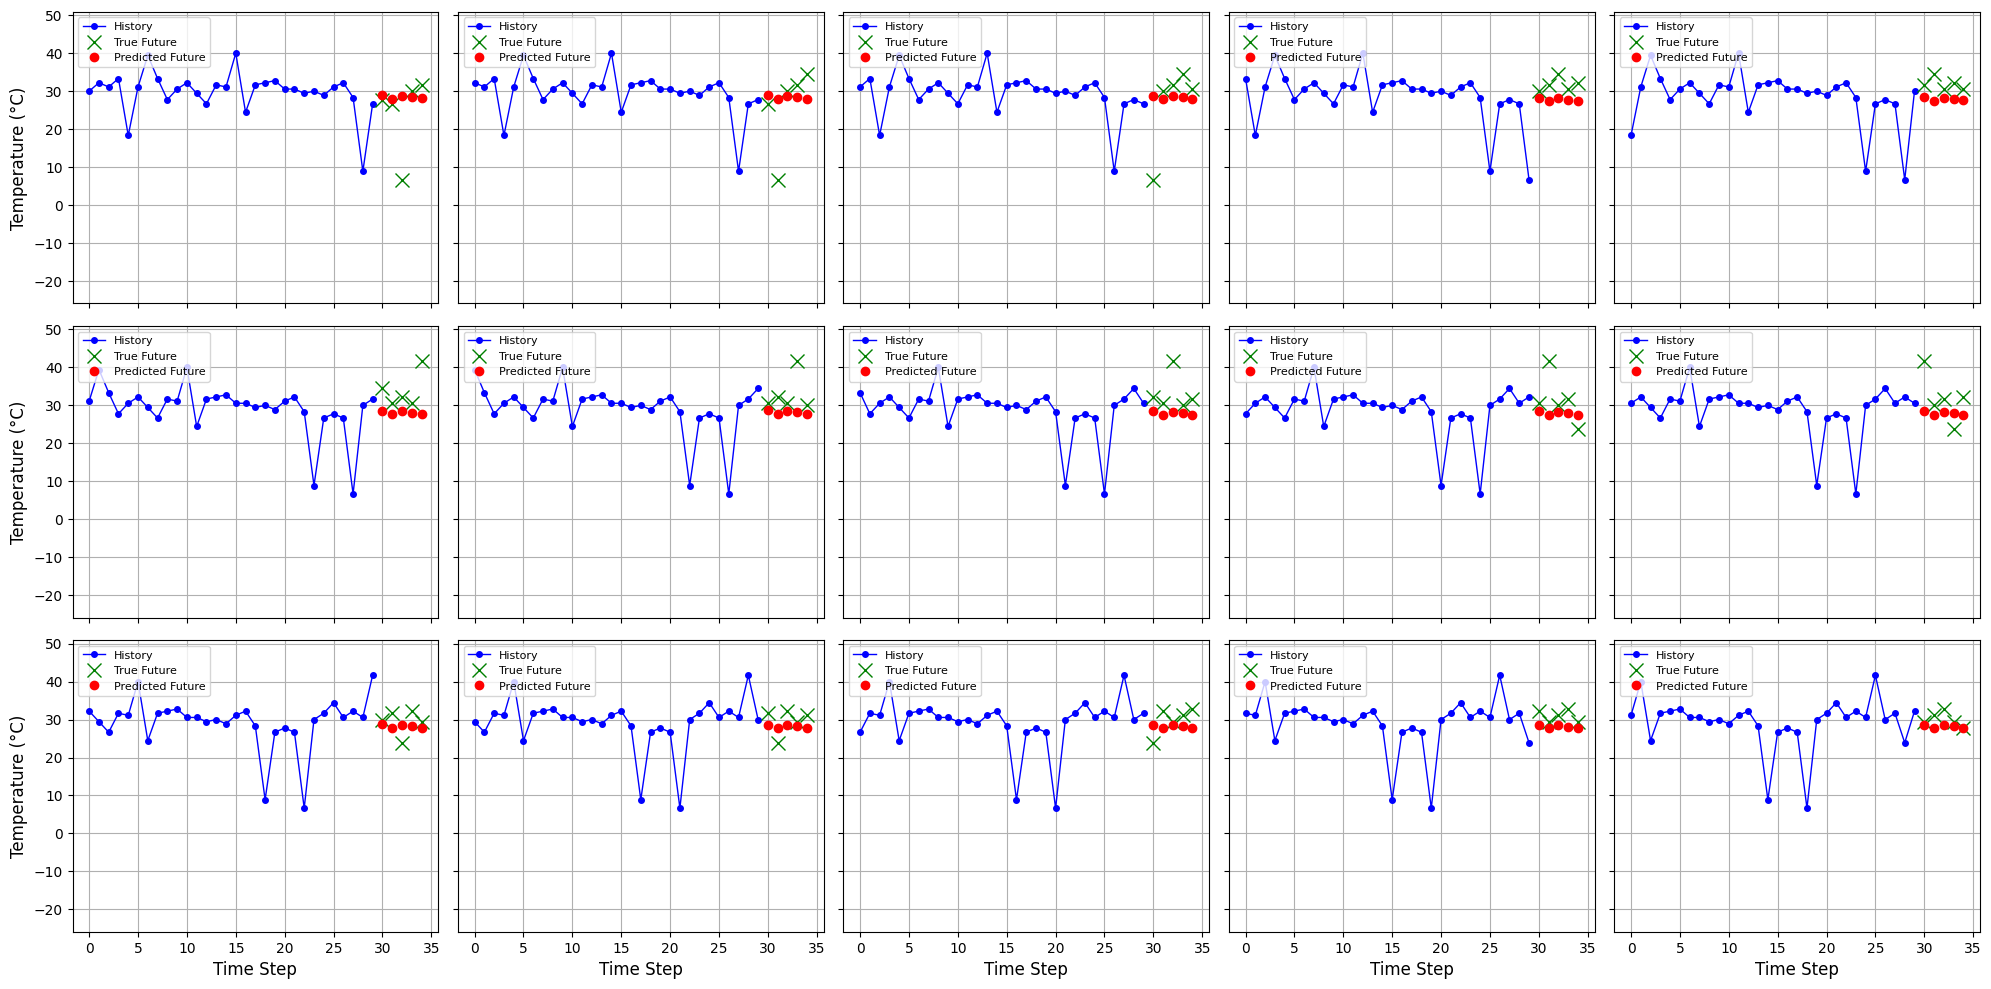

65.10541172135153

In [169]:
from sklearn.metrics import mean_squared_error
y_pred = predict(rnn, dataloader['test'],scaler)
# 将归一化的y_test逆转换回原始温度
X_test_actual = scaler.inverse_transform(X_test.reshape(-1, 1)).reshape(X_test.shape)
#print(X_test_actual)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)
#print(y_test_actual)
y_pred= scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)
#print(y_pred)
plot_series(X_test_actual, y_test_actual, y_pred)
mean_squared_error(y_test_actual, y_pred)